In [32]:
import yfinance as yf
import pandas as pd
import os


In [33]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [34]:
sp500.index = pd.to_datetime(sp500.index)

C:\Users\Prajw\AppData\Local\Temp\ipykernel_16844\318495744.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  sp500.index = pd.to_datetime(sp500.index)


In [35]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-01-02 00:00:00-05:00,4745.200195,4754.330078,4722.669922,4742.830078,3743050000,0.0,0.0
2024-01-03 00:00:00-05:00,4725.069824,4729.290039,4699.709961,4704.810059,3950760000,0.0,0.0
2024-01-04 00:00:00-05:00,4697.419922,4726.779785,4687.529785,4688.680176,3715480000,0.0,0.0


<Axes: xlabel='Date'>

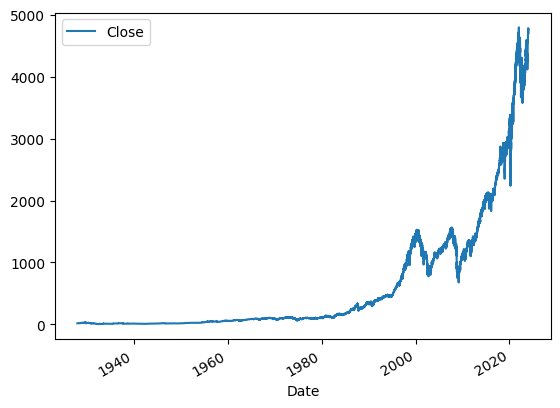

In [36]:
sp500.plot.line(y="Close", use_index=True)

In [37]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [38]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [39]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [42]:
sp500 = sp500.loc["1990-01-01":].copy()

TypeError: '<' not supported between instances of 'Timestamp' and 'str'

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5370370370370371

<Axes: xlabel='Date'>

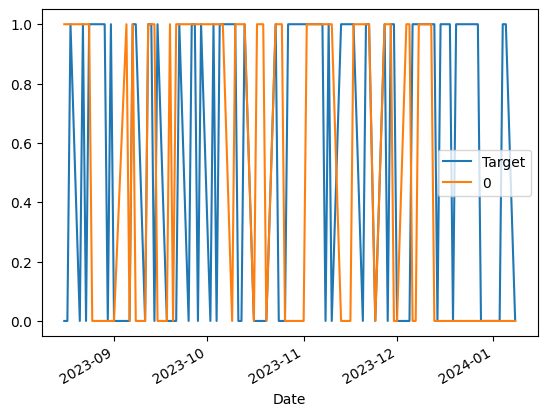

In [ ]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(sp500, model, predictors)

In [ ]:
predictions["Predictions"].value_counts()

Predictions
0    3474
1    2596
Name: count, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5288906009244992

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.534432
0    0.465568
Name: count, dtype: float64

In [ ]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [ ]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [ ]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-02 00:00:00-05:00,4745.200195,4754.330078,4722.669922,4742.830078,3743050000,4704.810059,0,0.997162,0.0,0.994206,3.0,1.057911,38.0,1.106224,137.0,1.193872,529.0
2024-01-03 00:00:00-05:00,4725.069824,4729.290039,4699.709961,4704.810059,3950760000,4688.680176,0,0.995976,0.0,0.989137,2.0,1.047886,37.0,1.096485,136.0,1.183880,528.0
2024-01-04 00:00:00-05:00,4697.419922,4726.779785,4687.529785,4688.680176,3715480000,4697.240234,1,0.998283,0.0,0.989611,1.0,1.042927,36.0,1.091829,136.0,1.179404,528.0


In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
predictions = backtest(sp500, model, new_predictors)

In [ ]:
predictions["Predictions"].value_counts()

Predictions
0.0    4239
1.0     831
Name: count, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5728038507821901

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.544181
0    0.455819
Name: count, dtype: float64

In [ ]:
predictions

,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,1.0
2003-11-18 00:00:00-05:00,1,1.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,1,1.0
...,...,...
2024-01-02 00:00:00-05:00,0,0.0
2024-01-03 00:00:00-05:00,0,0.0
2024-01-04 00:00:00-05:00,1,0.0
